In [1]:
%matplotlib inline
import numpy as np  
import matplotlib.pyplot as plt
import netCDF4 as nc
import time

In [2]:
import matplotlib
# new for this gen of notebooks:
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'figure.facecolor': 'white'})

In [3]:
from scipy.interpolate import interp2d 

# Find particles that leave the shelf

In [4]:
# get regridded bathy

bpath = '/glade/p/work/chsharri/SimTurtle/For_CMS/'
bfile = 'HTx0.1_regrid.nc'

bdata = nc.Dataset(bpath+bfile,'r')
bathy = bdata.variables['HT'][0,:,:]*0.01 # convert to m
# this file was interpolated in the same manner as nest files
# notes said same lat/lon as nest files, but with higher latitude

blat = bdata.variables['lat'][:]
blon = bdata.variables['lon'][:]

In [5]:
# find masked elements and set them to zero for interpolator
# masked elements have huge values
# unamsk array
bathy.mask = np.ma.nomask
# make values greater than 10^6 = 0
bathy[bathy>1E6] = 0

## Interpolate to particle lat lon positions

In [6]:
year = 1
site = '6'

#release file to write to in input directory:
rname1 = "FL_big"
rname = "FL_big_"+ site

#Output directory
tfile = '/glade/p/work/chsharri/SimTurtle/expt/' + rname1 + '/expt_' + rname + '/output/traj_file_1.nc'
mydata = nc.Dataset(tfile,'r')

tmlat = mydata.variables['lat'][:]
tmlon = mydata.variables['lon'][:]
tmSST = mydata.variables['temperature'][:]
tmNPP = mydata.variables['salinity'][:] # = NPP
tmbioC = mydata.variables['zooplankton'][:] # = bioC

In [7]:
# make blon monotonically increasing
blon_old = blon
blon[blon<blon[0]] = blon[blon<blon[0]]+360  
# now goes from 250 +

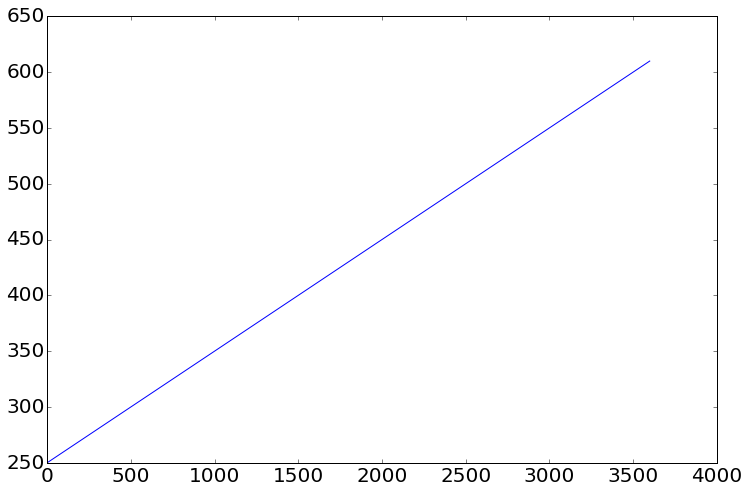

In [43]:
# this should be consistent with the domain I'm using (have to mod for other regions)
plt.plot(blon + 360)

In [8]:
# reduce size of the bathy array to 20-50 N and 90 to 10 W
imin = np.where(blat>20)[0][0]
imax = np.where(blat<50)[0][-1]
jmin = np.where(blon+360>(360-90))[0][0]
jmax = np.where(blon+360<(360-10))[0][-1]

In [9]:
print imin, imax, jmin, jmax
print blat[imin], blat[imax], blon[jmin], blon[jmax]

1386 1759 200 998
20.0790519714 49.9447860718 -89.9000015259 -10.1000003815


### Interpolate bathy

In [10]:
# interpolate with reduced array (note this saves minimal time)

# create interpolator function
# note that in this case bathy is n(blat)x n(blon), so blon goes first
f = interp2d(blon[jmin:jmax]+360, blat[imin:imax], bathy[imin:imax,jmin:jmax], kind = 'linear')

In [11]:
print time.ctime(time.time())

# interpolate to trajectory positions
#z = f(mylon,mylat)
tbathy = np.zeros_like(tmlat)

for release in np.arange(0,tbathy.shape[0]):
    for day in np.arange(0,tbathy.shape[1]):
        #print release,day
        tbathy[release,day] = f(tmlon[release,day],tmlat[release,day])

print time.ctime(time.time())

Mon Oct  2 09:54:08 2017
Mon Oct  2 09:57:12 2017


<matplotlib.colorbar.Colorbar instance at 0x2ba48ab08b48>

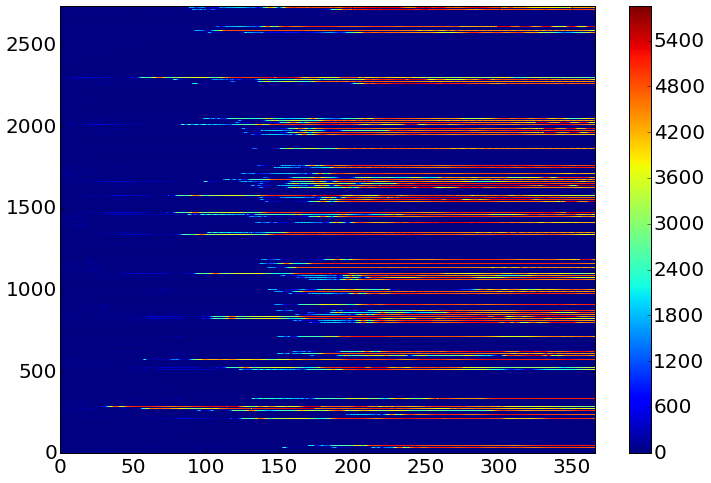

In [12]:
plt.pcolormesh(tbathy)
plt.axis('tight')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ba4a0087290>

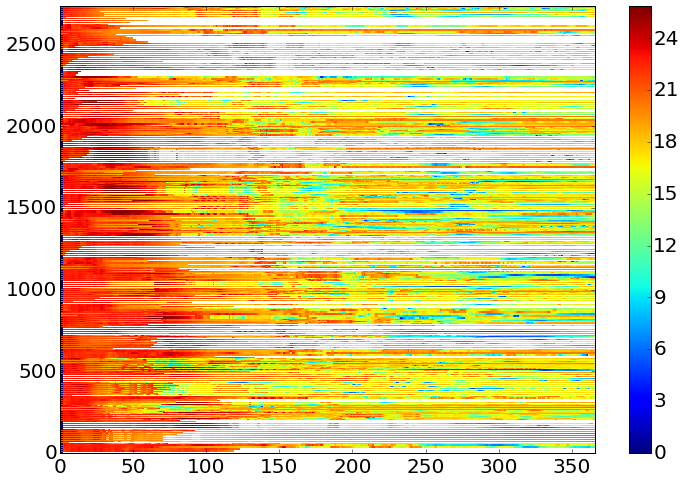

In [13]:
plt.pcolormesh(tmSST)
plt.axis('tight')
plt.colorbar()

In [14]:
# want to apply mask from tmSST to tbathy
# first make a copy of tbathy
tbathy2 = np.copy(tbathy)

In [15]:
tbathy2 = np.ma.masked_where(np.ma.getmask(tmSST), tbathy2)

<matplotlib.colorbar.Colorbar instance at 0x2ba4a206fb90>

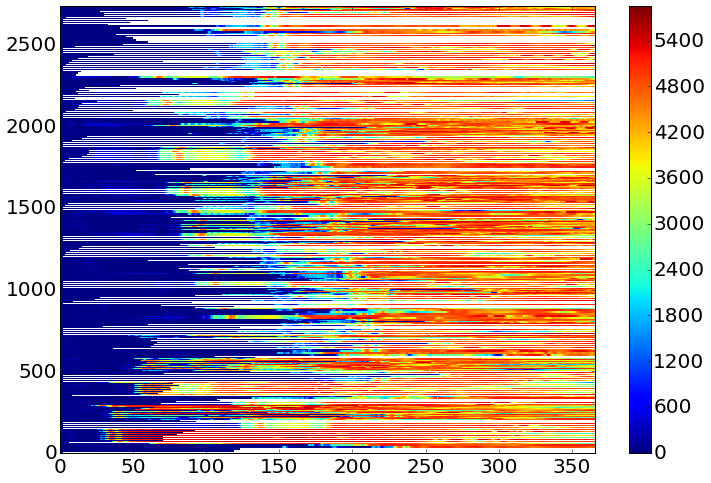

In [16]:
plt.pcolormesh(tbathy2)
plt.axis('tight')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2ba4a4029440>

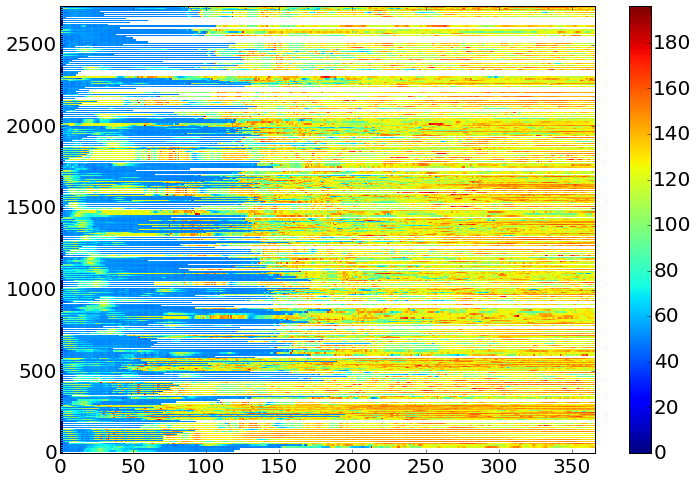

In [17]:
plt.pcolormesh(tmbioC)
plt.axis('tight')
plt.colorbar()

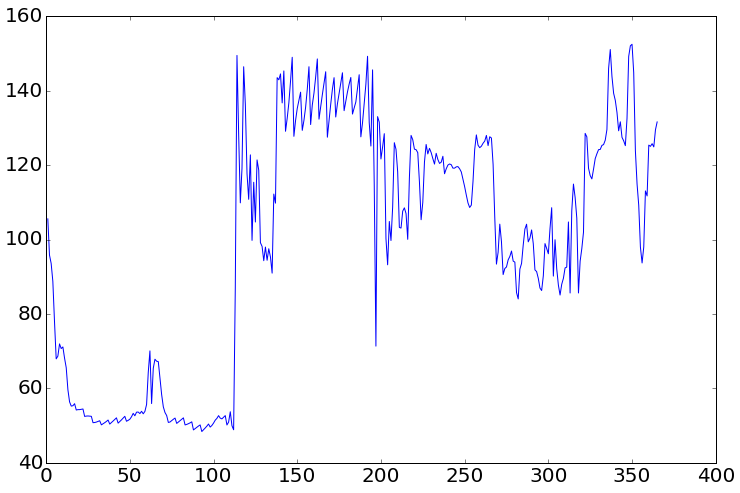

In [59]:
# use last release as test case
plt.plot(tmbioC[-1,:])

Apply mask of <100m to bioc

In [20]:
# calculate sum of bioC for all the points not over the shelf
# first apply mask (will this fix sum?)
tmbioC2 = np.ma.masked_where(tbathy2<100, tmbioC)

(array([ 2261.,     0.,     0.,     7.,    50.,   145.,    96.,    60.,
           75.,    42.]),
 array([   0.        ,   58.4194397 ,  116.83887939,  175.25831909,
         233.67775879,  292.09719849,  350.51663818,  408.93607788,
         467.35551758,  525.77495728,  584.19439697]),
 <a list of 10 Patch objects>)

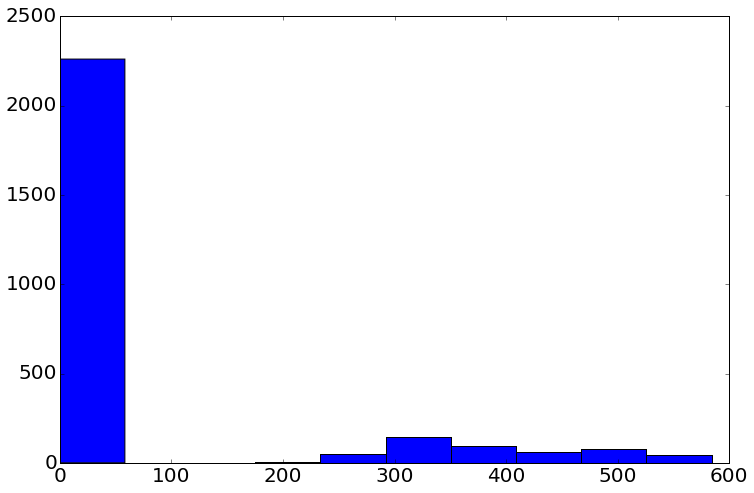

In [71]:
# sum bioC over the year
zooC_sum2 = np.sum(tmbioC2,axis=1)
plt.hist(zooC_sum2*12*0.001)

(array([  2.19700000e+03,   6.40000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.32000000e+02,   1.83000000e+02,   1.09000000e+02,
          4.90000000e+01]),
 array([   0.        ,   60.22236938,  120.44473877,  180.66710815,
         240.88947754,  301.11184692,  361.33421631,  421.55658569,
         481.77895508,  542.00132446,  602.22369385]),
 <a list of 10 Patch objects>)

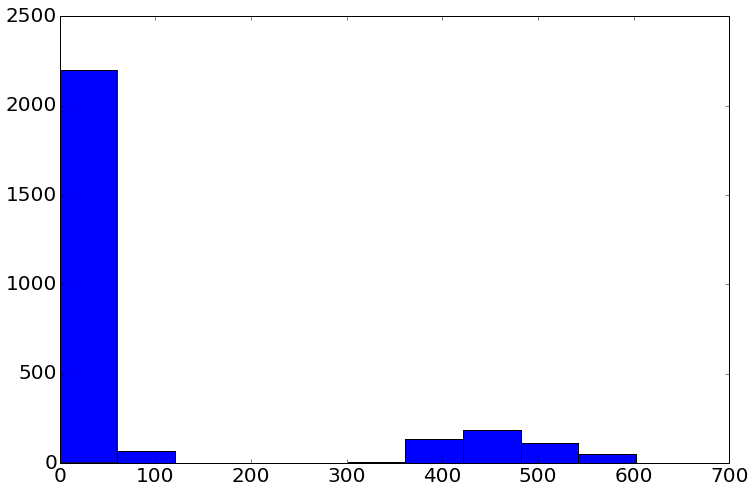

In [72]:
# sum bioC over the year
zooC_sum = np.sum(tmbioC,axis=1)
plt.hist(zooC_sum*12*0.001)

Problem is they have different amounts of time off the shelf, so it is not a good comparison

That didn't really work the way I wanted. Next idea is to start sum of bioc at day particle leaves the shelf

Want to plot the food as a function of days off the shelf. Does this change between sites?

<matplotlib.colorbar.Colorbar instance at 0x2ba4a60de128>

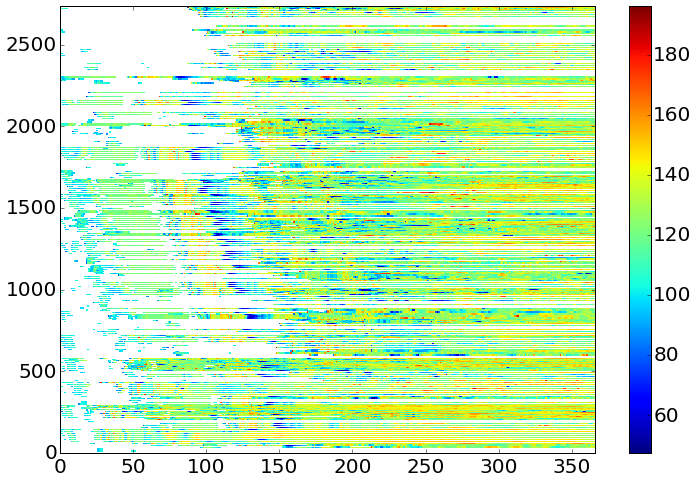

In [21]:
plt.pcolormesh(tmbioC2)
plt.axis('tight')
plt.colorbar()

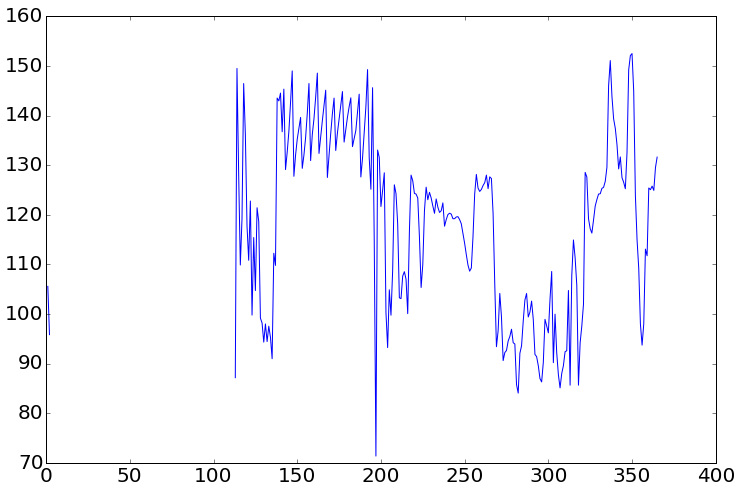

In [22]:
# use last release as test case
plt.plot(tmbioC2[-1,:])

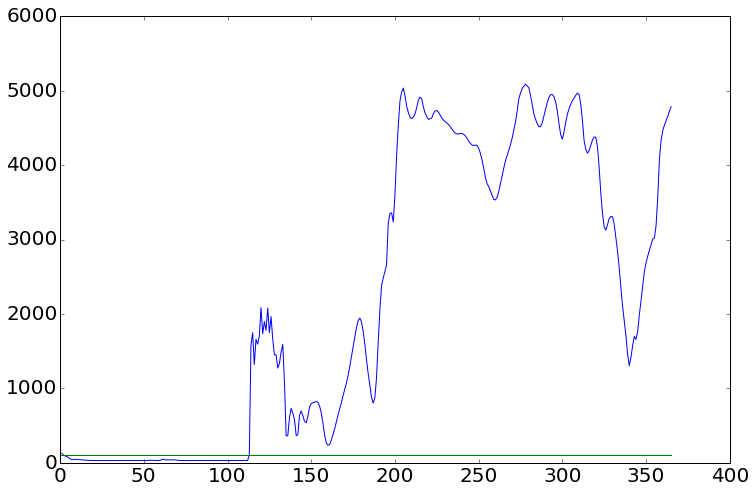

In [18]:
plt.plot(tbathy2[-1,:])
test = np.zeros_like(tbathy2[-1,:])
test[:]=100
plt.plot(test)

In [ ]:
# find index after last index on the shelf
# or simply collapse 
# again first row is a good sample as it starts deeper than 100 m then goes back

# find last masked element in tmbioc2 and start cumsum from there


In [36]:
# find index of last day over the shelf for each particle
shelf_ind = np.zeros([tbathy2.shape[0]])
# loop over particles
for particle in range(0,tbathy2.shape[0]):
    shelf_ind[particle] =  np.where(tbathy2[particle,:]<100)[0][-1]

In [53]:
# use this index to start a cumsum of food since time off shelf

cum_food = np.zeros_like(tbathy2)

for particle in range(0,tbathy2.shape[0]):
    cum_food_temp= np.cumsum(tmbioC[particle,shelf_ind[particle]+1::]) 
    cum_food[particle,0:cum_food_temp.size] = cum_food_temp

# mask out zeros
cum_food = np.ma.masked_where(cum_food <1, cum_food)

<matplotlib.colorbar.Colorbar instance at 0x2ba4ac3f4758>

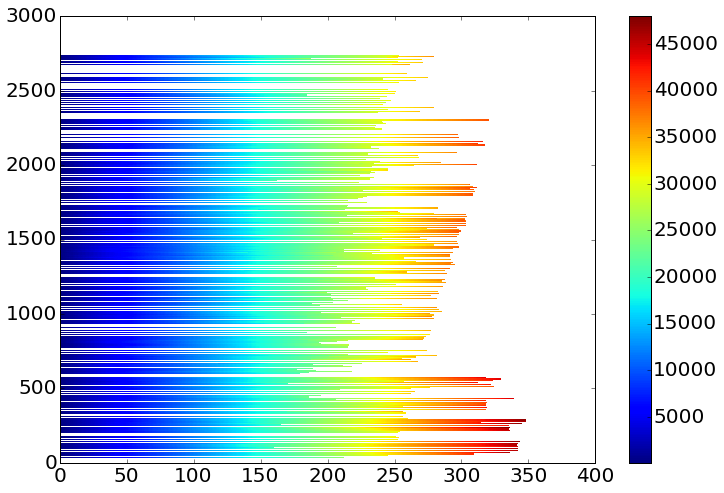

In [54]:
plt.pcolormesh(cum_food)
plt.colorbar()

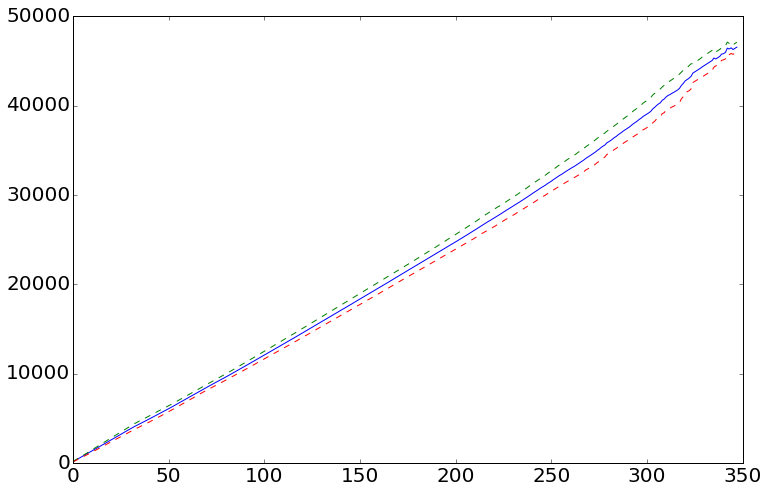

In [58]:
# find mean and std
mean_food = np.mean(cum_food, axis = 0)
std_food = np.std(cum_food, axis = 0)
plt.plot(mean_food)
plt.plot(mean_food + std_food,'--')
plt.plot(mean_food - std_food,'--')